In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
from scipy.signal import argrelextrema
import numpy as np

In [2]:
DATA_PATH = ('cases_month.csv')

data = pd.read_csv(DATA_PATH)

data.head()

,region,country,iso3,year,month,measles_suspect,measles_clinical,measles_epi_linked,measles_lab_confirmed,measles_total,rubella_clinical,rubella_epi_linked,rubella_lab_confirmed,rubella_total,discarded
0,AFR,Algeria,DZA,2012,1,8.0,6.0,0.0,2.0,8.0,NaN,NaN,NaN,NaN,0.0
1,AFR,Algeria,DZA,2012,2,10.0,10.0,0.0,0.0,10.0,NaN,NaN,NaN,NaN,0.0
2,AFR,Algeria,DZA,2012,3,17.0,17.0,0.0,0.0,17.0,NaN,NaN,NaN,NaN,0.0
3,AFR,Algeria,DZA,2012,4,7.0,5.0,0.0,0.0,5.0,0.0,0.0,1.0,1.0,2.0
4,AFR,Algeria,DZA,2012,5,14.0,11.0,0.0,0.0,11.0,0.0,0.0,3.0,3.0,3.0


In [3]:
# Add date column
data["date"] = pd.to_datetime(data[["year", "month"]].assign(DAY=1))
# Add country column
region_mapping = {
    "AFR": "African Region",
    "AMR": "American Region",
    "SEAR": "South-East Asian Region",
    "EUR": "European Region",
    "EMR": "East Mediterranean Region",
    "WPR": "West Pacific Region"
}
data["region_name"] = data["region"].map(region_mapping)

In [4]:
data.head()

,region,country,iso3,year,month,measles_suspect,measles_clinical,measles_epi_linked,measles_lab_confirmed,measles_total,rubella_clinical,rubella_epi_linked,rubella_lab_confirmed,rubella_total,discarded,date,region_name
0,AFR,Algeria,DZA,2012,1,8.0,6.0,0.0,2.0,8.0,NaN,NaN,NaN,NaN,0.0,2012-01-01,African Region
1,AFR,Algeria,DZA,2012,2,10.0,10.0,0.0,0.0,10.0,NaN,NaN,NaN,NaN,0.0,2012-02-01,African Region
2,AFR,Algeria,DZA,2012,3,17.0,17.0,0.0,0.0,17.0,NaN,NaN,NaN,NaN,0.0,2012-03-01,African Region
3,AFR,Algeria,DZA,2012,4,7.0,5.0,0.0,0.0,5.0,0.0,0.0,1.0,1.0,2.0,2012-04-01,African Region
4,AFR,Algeria,DZA,2012,5,14.0,11.0,0.0,0.0,11.0,0.0,0.0,3.0,3.0,3.0,2012-05-01,African Region


In [5]:
# Region and column selection
target_region = "African Region"
target_column = "measles_total"
region_data = data[data["region_name"] == target_region]

In [6]:
region_data.head()

,region,country,iso3,year,month,measles_suspect,measles_clinical,measles_epi_linked,measles_lab_confirmed,measles_total,rubella_clinical,rubella_epi_linked,rubella_lab_confirmed,rubella_total,discarded,date,region_name
0,AFR,Algeria,DZA,2012,1,8.0,6.0,0.0,2.0,8.0,NaN,NaN,NaN,NaN,0.0,2012-01-01,African Region
1,AFR,Algeria,DZA,2012,2,10.0,10.0,0.0,0.0,10.0,NaN,NaN,NaN,NaN,0.0,2012-02-01,African Region
2,AFR,Algeria,DZA,2012,3,17.0,17.0,0.0,0.0,17.0,NaN,NaN,NaN,NaN,0.0,2012-03-01,African Region
3,AFR,Algeria,DZA,2012,4,7.0,5.0,0.0,0.0,5.0,0.0,0.0,1.0,1.0,2.0,2012-04-01,African Region
4,AFR,Algeria,DZA,2012,5,14.0,11.0,0.0,0.0,11.0,0.0,0.0,3.0,3.0,3.0,2012-05-01,African Region


In [7]:
# Time grid
region_data = data.set_index("date")
region_data = region_data[[target_column]].resample('MS').sum()
region_data = region_data.interpolate(method="linear")

In [8]:
region_data.head()

,measles_total
date,
2012-01-01,15412.0
2012-02-01,14289.0
2012-03-01,15242.0
2012-04-01,13290.0
2012-05-01,12582.0


In [9]:
# Local max/min
maxima_indices = argrelextrema(region_data[target_column].values, np.greater, order=3)[0]
minima_indices = argrelextrema(region_data[target_column].values, np.less, order=3)[0]

maxima_dates = region_data.index[maxima_indices]
maxima_values = region_data[target_column].iloc[maxima_indices]

minima_dates = region_data.index[minima_indices]
minima_values = region_data[target_column].iloc[minima_indices]

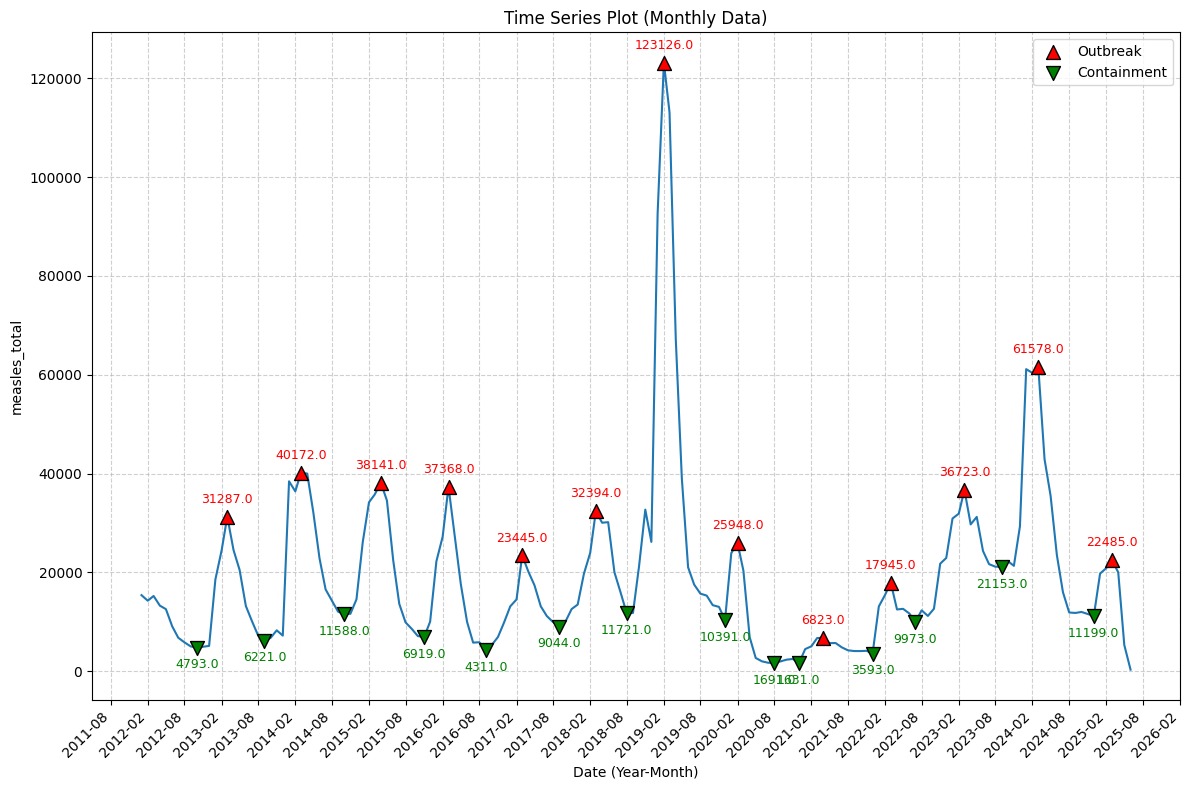

In [10]:
# Time series plot
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(region_data.index, region_data[target_column])

# extrema points
ax.scatter(maxima_dates, maxima_values, color='red', s=100, zorder=5, 
           label='Outbreak', marker='^', edgecolor='black')
for date, value in zip(maxima_dates, maxima_values):
    ax.annotate(f'{value:.1f}', (date, value), textcoords="offset points", 
                xytext=(0, 10), ha='center', color='red', fontsize=9)

ax.scatter(minima_dates, minima_values, color='green', s=100, zorder=5, 
           label='Containment', marker='v', edgecolor='black')
for date, value in zip(minima_dates, minima_values):
    ax.annotate(f'{value}', (date, value), textcoords="offset points", 
                xytext=(0, -15), ha='center', color='green', fontsize=9)

# axis tick
major_locator = mdates.MonthLocator(interval=6)
ax.xaxis.set_major_locator(major_locator)
major_formatter = mdates.DateFormatter('%Y-%m')
ax.xaxis.set_major_formatter(major_formatter)
fig.autofmt_xdate(rotation=45)

ax.set_title('Time Series Plot (Monthly Data)')
ax.set_xlabel('Date (Year-Month)')
ax.set_ylabel(target_column)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()

plt.tight_layout()
plt.show()

In [13]:
# Time grid
filtered = data[["date", "region_name", target_column]]

df_pivot = filtered.pivot_table(
    index="date",
    columns="region_name",
    values=target_column,
    aggfunc="sum",
    fill_value=0
)
df_final = df_pivot.stack().reset_index(name=target_column)

print(df_final["date"].unique())

<DatetimeArray>
['2012-01-01 00:00:00', '2012-02-01 00:00:00', '2012-03-01 00:00:00',
 '2012-04-01 00:00:00', '2012-05-01 00:00:00', '2012-06-01 00:00:00',
 '2012-07-01 00:00:00', '2012-08-01 00:00:00', '2012-09-01 00:00:00',
 '2012-10-01 00:00:00',
 ...
 '2024-09-01 00:00:00', '2024-10-01 00:00:00', '2024-11-01 00:00:00',
 '2024-12-01 00:00:00', '2025-01-01 00:00:00', '2025-02-01 00:00:00',
 '2025-03-01 00:00:00', '2025-04-01 00:00:00', '2025-05-01 00:00:00',
 '2025-06-01 00:00:00']
Length: 162, dtype: datetime64[ns]


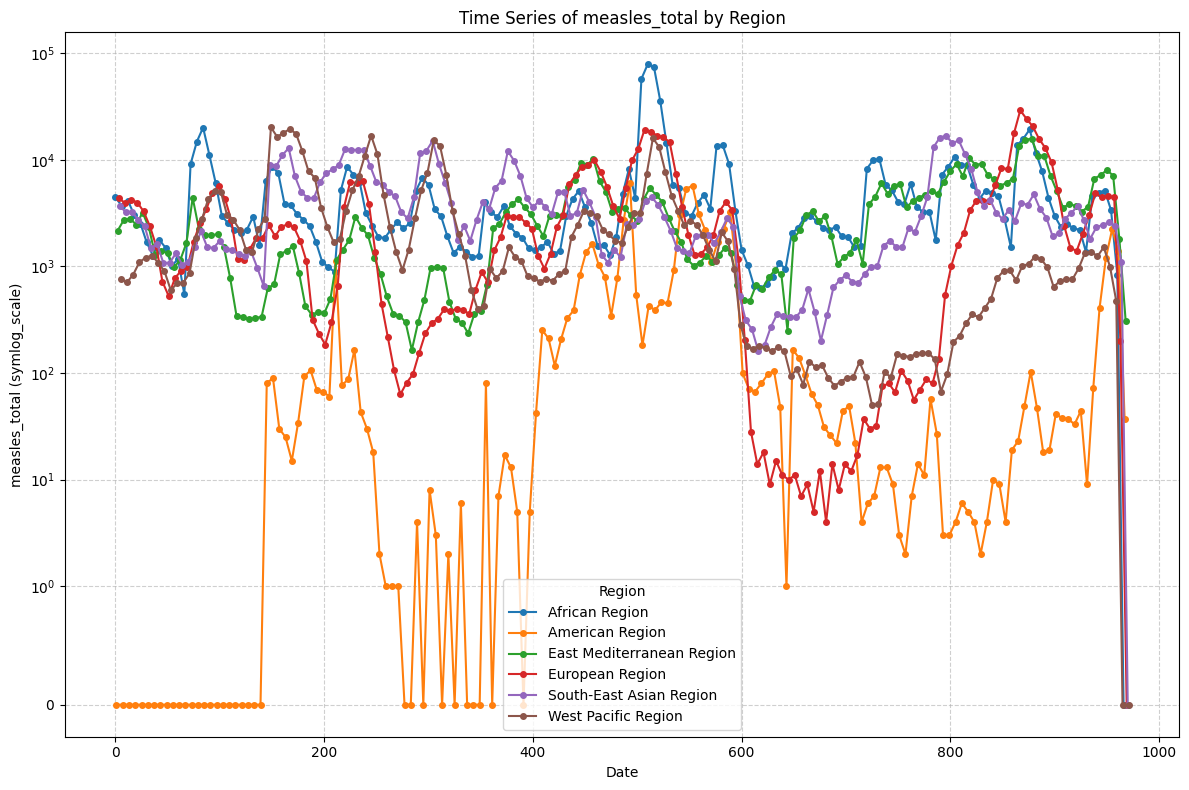

In [15]:
fig, ax = plt.subplots(figsize=(12,8))
grouped_regions = df_final.groupby("region_name")

for region, df in grouped_regions:
    ax.plot(df.index, df[target_column], label=region, marker='o', linestyle='-', markersize=4)

ax.set_title(f"Time Series of {target_column} by Region")
ax.set_xlabel('Date')
ax.set_yscale('symlog', linthresh=1) # symlog scale
ax.set_ylabel(f"{target_column} (symlog_scale)")
ax.legend(title = 'Region')
ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()